# **Deep Learning for Sensors Networks**
# Week 7 - Lab

This is your chance to try out RNNs on a real data set. The data set contains 2000 data points recorded by an indoor light sensor (light dependent resistor) over a period of about 20 days. 

The data set can be found here:
https://github.com/djdunc/casa0018/tree/main/Week7

Download it to your local machine.

To get you started I've include some code to load the data into a Python dataframe and split the data into train and validate sets.

Your tasks is to build both a vanilla RNN and LSTM, train them on the data set and use them to perform forecasting. The tasks are outlined in more detail later in the notebook.



# Set up the imports

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import tensorflow as tf

#additional libraries
import datetime, os



# Load sensor data from csv file

In [ ]:

from google.colab import files
uploaded = files.upload()

# Load into a dataframe

In [ ]:
df = pd.read_csv('light-2000.csv')
print(len(df))
print(df)
df.plot()

# Split into Train and Validate sets

2001
1801
200


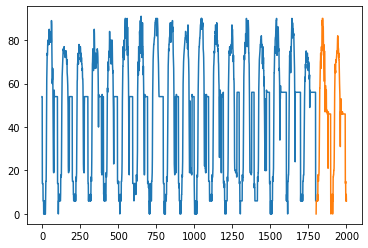

In [ ]:
print(len(df)) 
test_percent = 0.1   # 10 percent of data
test_point = np.round(len(df)*test_percent) 
test_index = int(len(df) - test_point)
train = df.iloc[:test_index]
test = df.iloc[test_index:]

print(len(train))
print(len(test))

plt.plot(train)
plt.plot(test)


# Your Tasks

*   Build and train a vanilla RNN
*   Check your model against the validation data set
*   Use your model to forecast 100 steps into the future

Repeat the above steps for a LSTM 



# Things to explore

*  Sequence length - How does the sequence length affect training time? Why?

*  Batch size - How does batch size affect training time? Why?

*  Number of RNN layers - what happens if you add a second recurrent layer to your model? Here is the code to do this for a vanilla RNN. The code for a LSTM is similar.
```
rnn_model.add(SimpleRNN(output_space, return_sequences=True, input_shape = (length , n_features)))
rnn_model.add(SimpleRNN(output_space))
```





## **Build and train a vanilla RNN**

# **Normalisaiton of data**

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# **Time Series Generator**
One problem we’ll face when using time series data is, we must transform the data into sequences of samples with input data and target data before feeding it into the model. We should select the length of the data sequence (window length) in such a way so that the model has an adequate amount of input data to generalize and predict, which means adjusting the length of the sequence to the length of one cycle, at least.

Looking at the plot above it seems three cycles are completed within 250 datapoints, 100 seems suitable as sequence length.

*Note from Martin - 100 is a fairly big size and might cause some troubles when unrolling the model*

In [ ]:
length = 100 # sequence length - the length of the training window
batch_size = 10

generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

print(len(scaled_train)) # 501
print(generator.length) # 451

NameError: ignored

## Create a model and train it
The code to create a RNN is similar to that for earlier NNs you have already seen, although here we use a SimpleRNN layer.

The variable (n_features) defined stands for the number of features in the training data i.e., as we are dealing with univariate data we’ll only have one feature whereas if we are using multivariate data containing multiple features then we must specify the count of features in our data.

early_stop is a callback that stops the training if the validation loss fails to decrease over a number of epochs specified by the patience value (15).

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),"rnn")
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

n_features = 1
rnn_model = Sequential()
output_space = length # Same as number of time steps in the training window
rnn_model.add(SimpleRNN(output_space, return_sequences=False, input_shape = (length, n_features)))
#rnn_model.add(SimpleRNN(output_space))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='mse')
rnn_model.summary()
rnn_model.fit(generator, epochs=200, validation_data=validation_generator, callbacks=[early_stop, tensorboard])
%tensorboard --logdir logs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
171/171 [==============================] - 19s 100ms/step - loss: 0.5850 - val_loss: 0.1261
Epoch 2/200
171/171 [==============================] - 16s 96ms/step - loss: 0.1483 - val_loss: 0.0752
Epoch 3/200
171/171 [==============================] - 16s 96ms/step - loss: 0.0844 - val_loss: 0.0658
Epoch 4/200
171/171 [==============================] - 16s 96ms/step - loss: 0.0747 - val_loss: 0.0584
Epoch 5/200
171/171 [==============================] - 17s 97ms/step - loss: 0.0728 - val_loss: 0.052

## **Predict next value**

In [ ]:
first_eval_batch = scaled_train[-length:] # Take the last 50 points and predict the new value in the scaled_test
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) # shape the data to match the input_shape of model
print(rnn_model.predict(first_eval_batch))
print(scaled_test[0])

NameError: ignored